In [1]:
# imports 
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import pathlib
from datetime import datetime
from dataclasses import dataclass
import math
import pyfao56 as fao 
from eto import ETo
import sqlite3


In [2]:
#loading weather data file 
con = sqlite3.connect('solarData.sqlite')
df_weather_CEBIVE_raw = pd.read_sql_query("SELECT * from cebiveSolarDailyHourly", con)
df_precipitation_CEBIVE_raw = pd.read_sql_query("SELECT date, rain_1h from cebiveWeatherHourly", con)
df_weather_constanza_raw = pd.read_sql_query("SELECT * from constanzaSolarDailyHourly", con)
df_precipitation_constanza_raw = pd.read_sql_query("SELECT date, rain_1h from constanzaWeatherHourly", con)
df_weather_losguineos_raw = pd.read_sql_query("SELECT * from losguineosSolarDailyHourly", con)
df_precipitation_losguineos_raw = pd.read_sql_query("SELECT date, rain_1h from losguineosWeatherHourly", con)
con.close()

df_weather_CEBIVE_raw


,iso_date,location,lat,lon,tz,date,Year,Month,Day,Hour,...,Clear_sky.dni,Cloudy_sky.ghi,Cloudy_sky.dni,Cloudy_sky.dhi,Temp,wind_speed,wind_deg,RH,pressure,rowid
0,2010-01-01 00:00:00,CEBIVE,18.54,-69.99,-4:00,2010-01-01,2010,1,1,0,...,0.0,0.0,0.0,0.0,24.60,2.70,45,80.04,1021,1
1,2010-01-01 01:00:00,CEBIVE,18.54,-69.99,-4:00,2010-01-01,2010,1,1,1,...,0.0,0.0,0.0,0.0,24.00,2.50,43,83.46,1021,2
2,2010-01-01 02:00:00,CEBIVE,18.54,-69.99,-4:00,2010-01-01,2010,1,1,2,...,0.0,0.0,0.0,0.0,23.50,2.30,40,86.56,1021,3
3,2010-01-01 03:00:00,CEBIVE,18.54,-69.99,-4:00,2010-01-01,2010,1,1,3,...,0.0,0.0,0.0,0.0,23.30,2.20,37,87.95,1020,4
4,2010-01-01 04:00:00,CEBIVE,18.54,-69.99,-4:00,2010-01-01,2010,1,1,4,...,0.0,0.0,0.0,0.0,23.30,2.20,37,88.16,1020,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122707,2023-12-31 19:00:00,CEBIVE,18.54,-69.99,-4:00,2023-12-31,2023,12,31,19,...,0.0,0.0,0.0,0.0,27.58,6.17,30,78.00,1017,122708
122708,2023-12-31 20:00:00,CEBIVE,18.54,-69.99,-4:00,2023-12-31,2023,12,31,20,...,0.0,0.0,0.0,0.0,25.50,3.09,20,89.00,1017,122709
122709,2023-12-31 21:00:00,CEBIVE,18.54,-69.99,-4:00,2023-12-31,2023,12,31,21,...,0.0,0.0,0.0,0.0,24.88,2.57,360,90.00,1017,122710
122710,2023-12-31 22:00:00,CEBIVE,18.54,-69.99,-4:00,2023-12-31,2023,12,31,22,...,0.0,0.0,0.0,0.0,25.09,5.14,180,90.00,1018,122711


In [3]:
#Preparing weather dataframe

#CEBIVE
df_weather_CEBIVE = df_weather_CEBIVE_raw.groupby('date').agg({'Temp': ['max', 'min'], 'RH': ['max', 'min'], 'pressure': 'mean', 'wind_speed': 'mean', 'Cloudy_sky.ghi': 'sum', 'Cloudy_sky.dni':'sum' })
df_weather_CEBIVE.columns = ['T_max', 'T_min', 'RH_max', 'RH_min' ,'P','U_2', 'GHI', 'DNI']
df_weather_CEBIVE['R_n'] = (0.77 * df_weather_CEBIVE['GHI'] + 0.25 * df_weather_CEBIVE['DNI']) * 3600 / 1e6 #in MJ/m2/day
df_weather_CEBIVE.drop(columns=['GHI', 'DNI'])
df_weather_CEBIVE.index = pd.to_datetime(df_weather_CEBIVE.index)

#Constanza
df_weather_constanza = df_weather_constanza_raw.groupby('date').agg({'Temp': ['max', 'min'], 'RH': ['max', 'min'], 'pressure': 'mean', 'wind_speed': 'mean', 'Cloudy_sky.ghi': 'sum', 'Cloudy_sky.dni':'sum' })
df_weather_constanza.columns = ['T_max', 'T_min', 'RH_max', 'RH_min' ,'P','U_2', 'GHI', 'DNI']
df_weather_constanza['R_n'] = (0.77 * df_weather_constanza['GHI'] + 0.25 * df_weather_constanza['DNI']) * 3600 / 1e6 #in MJ/m2/day
df_weather_constanza.drop(columns=['GHI', 'DNI'])
df_weather_constanza.index = pd.to_datetime(df_weather_constanza.index)

#Los Guineos
df_weather_losguineos = df_weather_losguineos_raw.groupby('date').agg({'Temp': ['max', 'min'], 'RH': ['max', 'min'], 'pressure': 'mean', 'wind_speed': 'mean', 'Cloudy_sky.ghi': 'sum', 'Cloudy_sky.dni':'sum' })
df_weather_losguineos.columns = ['T_max', 'T_min', 'RH_max', 'RH_min' ,'P','U_2', 'GHI', 'DNI']
df_weather_losguineos['R_n'] = (0.77 * df_weather_losguineos['GHI'] + 0.25 * df_weather_losguineos['DNI']) * 3600 / 1e6 #in MJ/m2/day
df_weather_losguineos.drop(columns=['GHI', 'DNI'])
df_weather_losguineos.index = pd.to_datetime(df_weather_losguineos.index)

df_weather_CEBIVE

,T_max,T_min,RH_max,RH_min,P,U_2,GHI,DNI,R_n
date,,,,,,,,,
2010-01-01,31.10,22.70,93.63,51.46,1018.083333,2.175000,4257.00,5082.00,16.374204
2010-01-02,31.40,23.50,87.16,49.48,1014.583333,1.129167,4009.00,4762.00,15.398748
2010-01-03,28.40,23.30,96.27,65.83,1014.041667,1.937500,1457.00,880.00,4.830804
2010-01-04,29.80,23.10,95.53,58.61,1014.500000,1.762500,3369.00,3841.00,12.795768
2010-01-05,30.70,23.40,94.39,47.34,1015.791667,1.479167,4557.00,5862.00,17.907804
...,...,...,...,...,...,...,...,...,...
2023-12-27,29.82,20.65,94.00,70.00,1014.875000,1.360417,5106.78,7367.48,20.786726
2023-12-28,29.05,20.01,100.00,67.00,1014.125000,1.046667,3735.19,2891.50,12.956297
2023-12-29,29.20,20.01,100.00,78.00,1015.375000,0.765000,5153.47,7524.14,21.057145


In [4]:
#prep precipitation data
# Replace empty strings with NaN values and convert to floats 
df_precipitation_CEBIVE_raw['rain_1h'] = pd.to_numeric(df_precipitation_CEBIVE_raw['rain_1h'], errors='coerce')
df_precipitation_CEBIVE_raw['rain_1h'].astype(float)

df_precipitation_constanza_raw['rain_1h'] = pd.to_numeric(df_precipitation_constanza_raw['rain_1h'], errors='coerce')
df_precipitation_constanza_raw['rain_1h'].astype(float)

df_precipitation_losguineos_raw['rain_1h'] = pd.to_numeric(df_precipitation_losguineos_raw['rain_1h'], errors='coerce')
df_precipitation_losguineos_raw['rain_1h'].astype(float)

# Group by the date column and sum the values for each date
df_precipitation_CEBIVE = df_precipitation_CEBIVE_raw.groupby('date').sum()
df_precipitation_constanza = df_precipitation_constanza_raw.groupby('date').sum()
df_precipitation_losguineos = df_precipitation_losguineos_raw.groupby('date').sum()

df_precipitation_CEBIVE.index = pd.to_datetime(df_precipitation_CEBIVE.index)
df_precipitation_constanza.index = pd.to_datetime(df_precipitation_constanza.index)
df_precipitation_losguineos.index = pd.to_datetime(df_precipitation_losguineos.index)

the maximum ETo for  CEBIVE is 7.86 mm/day 
the minimum ETo for CEBIVE is 1.02 mm/day 
the maximum ETo for Constanza is 7.14 mm/day 
the minimum ETo for Constanza is 0.3 mm/day 
the maximum ETo for los Guineos is 10.36 mm/day 
the minimum ETo for los Guineos is 1.56 mm/day 


/usr/local/lib/python3.11/site-packages/eto/param_est.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.ts_param['e_a'].loc[self.ts_param['e_a'].isnull()] = (self.ts_param['e_min'][self.ts_param['e_a'].isnull()] * self.ts_param.loc[self.ts_param['e_a'].isnull(), 'RH_max']/100 + self.ts_param['e_max'][self.ts_param['e_a'].isnull()] * self.ts_param.loc[self.ts_param['e_a'].isnull(), 'RH_min']/100)/2
/usr/local/lib/python3.11/site-packages/eto/param_est.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.ts_param['e_a'].loc[self.ts_param['e_a'].isnull()] = self.ts_param.loc[self.ts_param['e_a'].isnull(), '

Text(0, 0.5, 'mm/day')

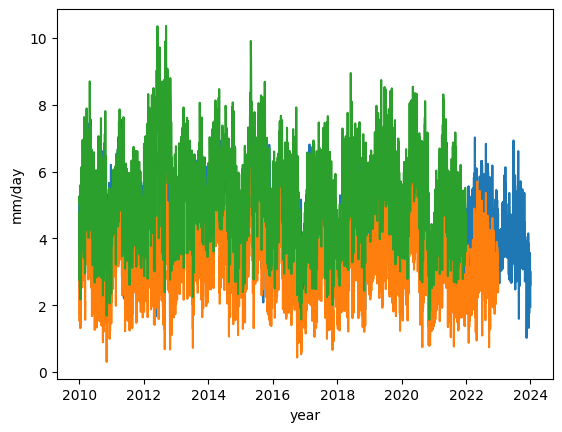

In [5]:
#ETo for different locations

#@CEBIVE
et1 = ETo()
et1.param_est(df= df_weather_CEBIVE, freq='D', z_msl=10, lat=18.54, lon=-69.99, TZ_lon=-60.00, z_u=2, K_rs=0.16, a_s=0.25, b_s=0.5, alb=0.23)
et1.ts_param.head()
ETo_results_CEBIVE = et1.eto_fao()
max_ETo_CEBIVE = max(ETo_results_CEBIVE)
print(f"the maximum ETo for  CEBIVE is {max_ETo_CEBIVE} mm/day ")
min_ETo_CEBIVE = min(ETo_results_CEBIVE)
print(f"the minimum ETo for CEBIVE is {min_ETo_CEBIVE} mm/day ")

#@Constanza
et2 = ETo()
et2.param_est(df= df_weather_constanza, freq='D', z_msl=1164, lat=18.92, lon=-69.99, TZ_lon=-70.73, z_u=2, K_rs=0.16, a_s=0.25, b_s=0.5, alb=0.23)
et2.ts_param.head()
ETo_results_constanza = et2.eto_fao()
max_ETo_constanza = max(ETo_results_constanza)
print(f"the maximum ETo for Constanza is {max_ETo_constanza} mm/day ")
min_ETo_constanza = min(ETo_results_constanza)
print(f"the minimum ETo for Constanza is {min_ETo_constanza} mm/day ")

#@Los Guineos
et3 = ETo()
et3.param_est(df= df_weather_losguineos, freq='D', z_msl=175, lat=19.32, lon=-70.43, TZ_lon=-60.00, z_u=2, K_rs=0.16, a_s=0.25, b_s=0.5, alb=0.23)
et3.ts_param.head()
ETo_results_losguineos = et3.eto_fao()
max_ETo_losguineos = max(ETo_results_losguineos)
print(f"the maximum ETo for los Guineos is {max_ETo_losguineos} mm/day ")
min_ETo_losguineos = min(ETo_results_losguineos)
print(f"the minimum ETo for los Guineos is {min_ETo_losguineos} mm/day ")

plt.plot(ETo_results_CEBIVE)
plt.plot(ETo_results_constanza)
plt.plot(ETo_results_losguineos)
plt.xlabel('year')
plt.ylabel('mm/day')



Text(0, 0.5, 'mm/day')

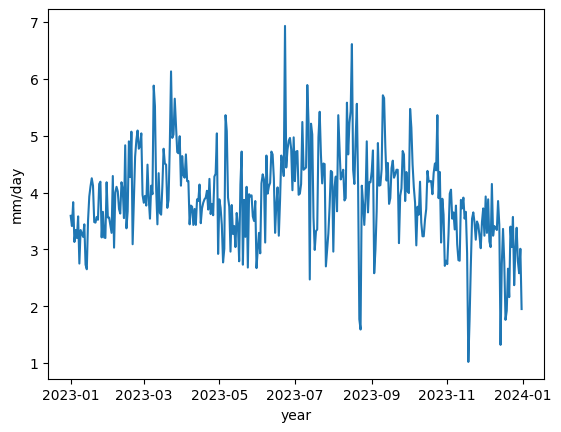

In [6]:
results_2023 = ETo_results_CEBIVE['2023']
plt.plot(results_2023)
plt.xlabel('year')
plt.ylabel('mm/day')

In [28]:
#plantians @ CEBIVE
kc_plantains = 0.88 #Goenaga et al (1995)
df_plantains = pd.DataFrame()
df_plantains['ETc_plantains'] = kc_plantains * ETo_results_CEBIVE #mm/day
df_plantains['rainfall'] = df_precipitation_CEBIVE['rain_1h'] #mm/day

df_plantains['effective_rainfall'] = np.where(df_plantains['rainfall'] > 2.5, (0.8/30) * df_plantains['rainfall'] - (25/30), (0.6/30) * df_plantains['rainfall'] - (10/30)) 
#from FAO section 4.4 (https://www.fao.org/3/s2022e/s2022e08.htm#4.2%20determination%20of%20the%20effective%20rainfall*) 
df_plantains['effective_rainfall'] = np.where(df_plantains['effective_rainfall'] < 0, 0, df_plantains['effective_rainfall']) #can never be less than zero 
df_plantains['irrigation need'] = df_plantains['ETc_plantains'] - df_plantains['effective_rainfall'] #mm/day
df_plantains['irrigation need'] = np.where(df_plantains['irrigation need'] < 0, 0, df_plantains['irrigation need']) #can never be less than zero 
# set to 0 if negative (https://extension.colostate.edu/topic-areas/agriculture/irrigation-scheduling-the-water-balance-approach-4-707/)


eff_drip = 0.9 #drip irrigation efficiency (Salem 2019)
LR = 0.2 #leaching requirement (Salem 2019)
A = 20* 100 #area of field (m2)
f_w = 0.3

L_plantain = 2 #m, distance between plantains 
n_rows = 4 #number of rows
n_plantains = (100/L_plantain) * n_rows  #number of plantains per plot (100 meter long rows with 4 rows per plot)

df_plantains['total irrigation need'] =  (A * df_plantains['irrigation need']*f_w) / 1000 #m3/day
df_plantains

,ETc_plantains,rainfall,effective_rainfall,irrigation need,total irrigation need
date,,,,,
2010-01-01,4.0568,0.00,0.0,4.0568,2.43408
2010-01-02,4.4352,0.93,0.0,4.4352,2.66112
2010-01-03,2.1736,0.41,0.0,2.1736,1.30416
2010-01-04,3.1856,1.10,0.0,3.1856,1.91136
2010-01-05,4.3032,0.00,0.0,4.3032,2.58192
...,...,...,...,...,...
2023-12-27,2.9744,0.00,0.0,2.9744,1.78464
2023-12-28,2.4552,0.00,0.0,2.4552,1.47312
2023-12-29,2.2704,0.00,0.0,2.2704,1.36224


In [34]:
#Tomatos @ Constanza

#Sarita Valdez (1993) --> tomatoes cultivated all year long in Constanza and Jarabocoa, 0.3 to 0.5m between plants 

kc_tomatoes = 1.15 #max from FAO  
df_tomatoes = pd.DataFrame()
df_tomatoes['ETc_tomatoes'] = kc_tomatoes * ETo_results_constanza #mm/day
df_tomatoes['rainfall'] = df_precipitation_constanza['rain_1h'] #mm/day

df_tomatoes['effective_rainfall'] = np.where(df_tomatoes['rainfall'] > 2.5, (0.8/30) * df_tomatoes['rainfall'] - (25/30), (0.6/30) * df_tomatoes['rainfall'] - (10/30)) 
#from FAO section 4.4 (https://www.fao.org/3/s2022e/s2022e08.htm#4.2%20determination%20of%20the%20effective%20rainfall*) 
df_tomatoes['effective_rainfall'] = np.where(df_tomatoes['effective_rainfall'] < 0, 0, df_tomatoes['effective_rainfall']) #can never be less than zero 
df_tomatoes['irrigation need'] = df_tomatoes['ETc_tomatoes'] - df_tomatoes['effective_rainfall'] #mm/day
df_tomatoes['irrigation need'] = np.where(df_tomatoes['irrigation need'] < 0, 0, df_tomatoes['irrigation need']) #can never be less than zero 
# set to 0 if negative (https://extension.colostate.edu/topic-areas/agriculture/irrigation-scheduling-the-water-balance-approach-4-707/)

L_tomato = 0.5 #m, distance between tomatoes
n_tomatoes = (100/L_tomato) * n_rows #number of tomatoes per plot (100 meter long rows with 4 rows per plot)
df_tomatoes['total irrigation need'] = (A * df_tomatoes['irrigation need']*f_w) / 1000 #m3/day #m3/day


df_tomatoes

,ETc_tomatoes,rainfall,effective_rainfall,irrigation need,total irrigation need
date,,,,,
2010-01-01,4.3930,0.00,0.0,4.3930,2.6358
2010-01-02,4.3585,12.66,0.0,4.3585,2.6151
2010-01-03,1.7480,9.05,0.0,1.7480,1.0488
2010-01-04,3.0590,4.91,0.0,3.0590,1.8354
2010-01-05,3.9560,10.91,0.0,3.9560,2.3736
...,...,...,...,...,...
2022-12-27,2.9325,0.11,0.0,2.9325,1.7595
2022-12-28,3.5190,0.37,0.0,3.5190,2.1114
2022-12-29,3.6110,0.85,0.0,3.6110,2.1666


In [35]:
#Eggplant @ Constanza 
# Morales Payán (1994) --> cultivated year round,  120 to 150 cm between plants 
kc_eggplant = 1.05 # Rivera (2006) for 120 cycle based on Morales Payán 
df_eggplant = pd.DataFrame()
#df_eggplant['ETc_eggplant'] = kc_eggplant * ETo_results_losguineos
#df_eggplant['rainfall'] = df_precipitation_losguineos['rain_1h']


df_eggplant['ETc_eggplant'] = kc_eggplant * ETo_results_constanza #mm/day
df_eggplant['rainfall'] = df_precipitation_constanza['rain_1h'] #mm/day

df_eggplant['effective_rainfall'] = np.where(df_eggplant['rainfall'] > 2.5, (0.8/30) * df_eggplant['rainfall'] - (25/30), (0.6/30) * df_eggplant['rainfall'] - (10/30)) 
#from FAO section 4.4 (https://www.fao.org/3/s2022e/s2022e08.htm#4.2%20determination%20of%20the%20effective%20rainfall*) 
df_eggplant['effective_rainfall'] = np.where(df_eggplant['effective_rainfall'] < 0, 0, df_eggplant['effective_rainfall']) #can never be less than zero 
df_eggplant['irrigation need'] = df_eggplant['ETc_eggplant'] - df_eggplant['effective_rainfall'] #mm/day
df_eggplant['irrigation need'] = np.where(df_eggplant['irrigation need'] < 0, 0, df_eggplant['irrigation need']) #can never be less than zero 
# set to 0 if negative (https://extension.colostate.edu/topic-areas/agriculture/irrigation-scheduling-the-water-balance-approach-4-707/)

L_eggplant = 1.2 #m, distance between eggplants
n_eggplant = (100/L_eggplant) * n_rows #number of eggplants per plot (100 meter long rows with 4 rows per plot)
df_eggplant['total irrigation need'] = (A * df_eggplant['irrigation need']*f_w) / 1000 #m3/day

#df_eggplant['total irrigation need'] = (A * df_eggplant['irrigation need']*10) / (eff_drip *(1-LR)) #m3/day
df_eggplant


,ETc_eggplant,rainfall,effective_rainfall,irrigation need,total irrigation need
date,,,,,
2010-01-01,4.0110,0.00,0.0,4.0110,2.4066
2010-01-02,3.9795,12.66,0.0,3.9795,2.3877
2010-01-03,1.5960,9.05,0.0,1.5960,0.9576
2010-01-04,2.7930,4.91,0.0,2.7930,1.6758
2010-01-05,3.6120,10.91,0.0,3.6120,2.1672
...,...,...,...,...,...
2022-12-27,2.6775,0.11,0.0,2.6775,1.6065
2022-12-28,3.2130,0.37,0.0,3.2130,1.9278
2022-12-29,3.2970,0.85,0.0,3.2970,1.9782


Text(0, 0.5, 'mm/day')

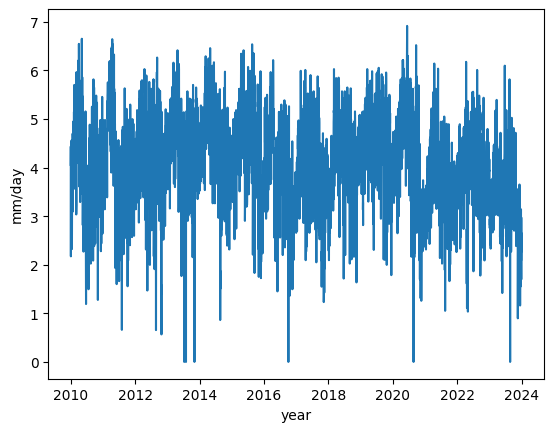

In [11]:
plt.plot(df_plantains['irrigation need'])
plt.xlabel('year')
plt.ylabel('mm/day')

the maximum ETo for  CEBIVE is 7.86 mm/day 
the minimum ETo for CEBIVE is 1.02 mm/day 
the maximum ETo for Constanza is 7.14 mm/day 
the minimum ETo for Constanza is 0.3 mm/day 
the maximum ETo for los Guineos is 10.36 mm/day 
the minimum ETo for los Guineos is 1.56 mm/day 


/usr/local/lib/python3.11/site-packages/eto/param_est.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.ts_param['e_a'].loc[self.ts_param['e_a'].isnull()] = (self.ts_param['e_min'][self.ts_param['e_a'].isnull()] * self.ts_param.loc[self.ts_param['e_a'].isnull(), 'RH_max']/100 + self.ts_param['e_max'][self.ts_param['e_a'].isnull()] * self.ts_param.loc[self.ts_param['e_a'].isnull(), 'RH_min']/100)/2
/usr/local/lib/python3.11/site-packages/eto/param_est.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.ts_param['e_a'].loc[self.ts_param['e_a'].isnull()] = self.ts_param.loc[self.ts_param['e_a'].isnull(), '

Text(0, 0.5, 'mm/day')

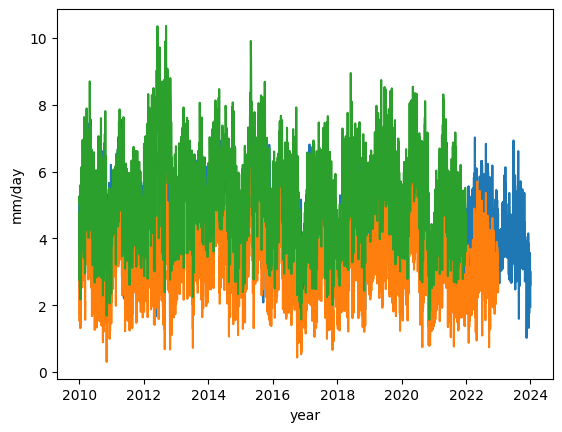

In [12]:
#ETo for different locations

#@CEBIVE
et1 = ETo()
et1.param_est(df= df_weather_CEBIVE, freq='D', z_msl=10, lat=18.54, lon=-69.99, TZ_lon=-60.00, z_u=2, K_rs=0.16, a_s=0.25, b_s=0.5, alb=0.23)
et1.ts_param.head()
ETo_results_CEBIVE = et1.eto_fao()
max_ETo_CEBIVE = max(ETo_results_CEBIVE)
print(f"the maximum ETo for  CEBIVE is {max_ETo_CEBIVE} mm/day ")
min_ETo_CEBIVE = min(ETo_results_CEBIVE)
print(f"the minimum ETo for CEBIVE is {min_ETo_CEBIVE} mm/day ")

#@Constanza
et2 = ETo()
et2.param_est(df= df_weather_constanza, freq='D', z_msl=1164, lat=18.92, lon=-69.99, TZ_lon=-70.73, z_u=2, K_rs=0.16, a_s=0.25, b_s=0.5, alb=0.23)
et2.ts_param.head()
ETo_results_constanza = et2.eto_fao()
max_ETo_constanza = max(ETo_results_constanza)
print(f"the maximum ETo for Constanza is {max_ETo_constanza} mm/day ")
min_ETo_constanza = min(ETo_results_constanza)
print(f"the minimum ETo for Constanza is {min_ETo_constanza} mm/day ")

#@Los Guineos
et3 = ETo()
et3.param_est(df= df_weather_losguineos, freq='D', z_msl=175, lat=19.32, lon=-70.43, TZ_lon=-60.00, z_u=2, K_rs=0.16, a_s=0.25, b_s=0.5, alb=0.23)
et3.ts_param.head()
ETo_results_losguineos = et3.eto_fao()
max_ETo_losguineos = max(ETo_results_losguineos)
print(f"the maximum ETo for los Guineos is {max_ETo_losguineos} mm/day ")
min_ETo_losguineos = min(ETo_results_losguineos)
print(f"the minimum ETo for los Guineos is {min_ETo_losguineos} mm/day ")

plt.plot(ETo_results_CEBIVE)
plt.plot(ETo_results_constanza)
plt.plot(ETo_results_losguineos)
plt.xlabel('year')
plt.ylabel('mm/day')



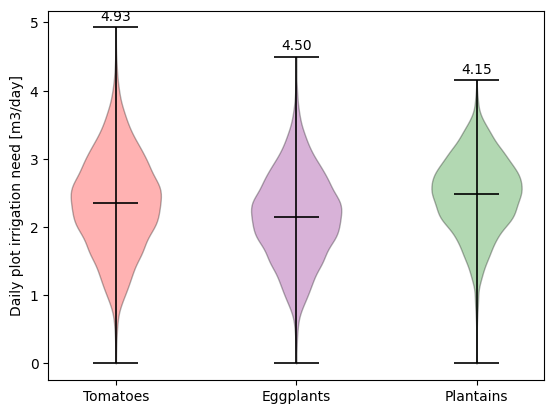

In [36]:
# box plot of irrigation need per day for 
colors = ['red', 'purple', 'green']
data =  df_tomatoes['total irrigation need'], df_eggplant['total irrigation need'],df_plantains['total irrigation need']
parts = plt.violinplot(data, showmeans=True)
plt.ylabel('Daily plot irrigation need [m3/day]')
plt.xticks([1, 2, 3], ['Tomatoes', 'Eggplants', 'Plantains'])
for i, (color, pc) in enumerate(zip(colors, parts['bodies'])):
    pc.set_facecolor(color)
    pc.set_edgecolor('black')

for partname in ('cbars', 'cmeans','cmaxes', 'cmins', ):
    vp = parts[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1.2) 

# Annotate maximum values
for i, d in enumerate(data):
    max_value = np.max(d)
    plt.annotate(f'{max_value:.2f}', xy=(i + 1, max_value), xytext=(0, +5), textcoords='offset points', ha='center', color='black')

#plt.yticks(np.arange(0, 9, 1))

plt.show()

the maximum irrigation need for the plot is 1.5370666666666668 m3/day or 6.9168 mm/plant/day 
the run time is 3.842666666666667 hours 


Text(0.5, 1.0, 'total plot irrigation need for plantains')

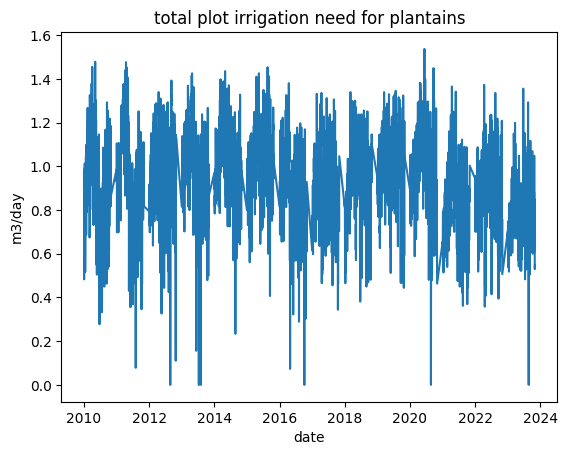

In [135]:

V_max = max(df_plantains['total irrigation need'])
print(f"the maximum irrigation need for the plot is {V_max} m3/day or {max_irrigation_plantains} mm/plant/day ")

#if running at nominal flow rate 
t_run = ((V_max/n_plantains) * 1000) /2 #hours 
print(f"the run time is {t_run} hours ")

plt.plot(df_plantains['total irrigation need'])
plt.xlabel('date')
plt.ylabel('m3/day')
plt.title('total plot irrigation need for plantains')

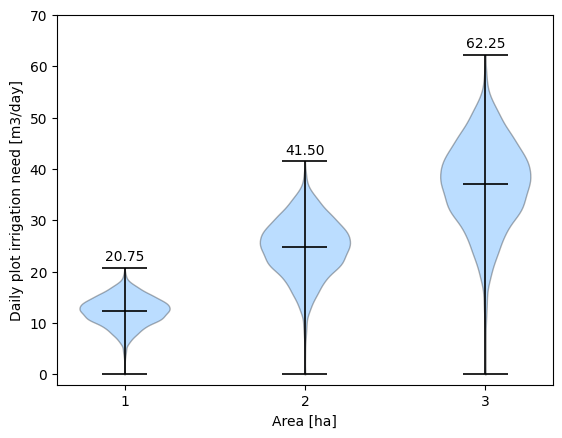

In [51]:
## Testing with different Areas per plot (PLANTAINS in CEBIVE)

df_areas = pd.DataFrame()
A_1 = 10000 #1 ha = 10000 m2 
df_areas['1 ha'] = (A_1 *1 * df_plantains['irrigation need']*f_w) / 1000 #m3/day
df_areas['2 ha'] = (A_1 *2 * df_plantains['irrigation need']*f_w) / 1000 #m3/day
df_areas['3 ha'] = (A_1 *3 * df_plantains['irrigation need']*f_w) / 1000 #m3/day


# box plot of irrigation need per day for different areas 
colors = ['dodgerblue', 'dodgerblue', 'dodgerblue']
data =  df_areas['1 ha'], df_areas['2 ha'], df_areas['3 ha']
parts = plt.violinplot(data, showmeans=True)
plt.ylabel('Daily plot irrigation need [m3/day]')
plt.xlabel('Area [ha]')
plt.xticks([1, 2, 3], ['1', '2', '3'])
for i, (color, pc) in enumerate(zip(colors, parts['bodies'])):
    pc.set_facecolor(color)
    pc.set_edgecolor('black')

for partname in ('cbars', 'cmeans','cmaxes', 'cmins', ):
    vp = parts[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1.2) 

# Annotate maximum values
for i, d in enumerate(data):
    max_value = np.max(d)
    plt.annotate(f'{max_value:.2f}', xy=(i + 1, max_value), xytext=(0, +5), textcoords='offset points', ha='center', color='black')

plt.yticks(np.arange(0,75, 10))
plt.ylim(-2, 70)

plt.show()
